In [ ]:
import sys, os
import geemap
from pathlib import Path
import numpy as np
import pandas as pd
from joblib import Memory

sys.path.append(os.path.abspath(".."))
# Resolve all data paths relative to the repo root
REPO_ROOT = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parents[0]

from config import load_city_config
from gee_utils import init_gee, export_image_to_gee, load_image_collection
from data_utils import load_gdb
from mappluto import perform_mappluto_eda
from geometry import get_city_geometry
from naip import calculate_spectral_indices

In [ ]:
memory = Memory(Path("cache"), verbose=0)

# Load city config
CONFIG = load_city_config("nyc", config_dir=REPO_ROOT / "config")
print(f"Loaded config for: {CONFIG.city_name}")

In [3]:
init_gee(CONFIG.EARTH_ENGINE)

23:24:38 | INFO | vacant_lots | Initializing GEE with ADC credentials and project:vacant-lot-detection
23:24:39 | INFO | vacant_lots | GEE sucessfully initialized


# Load Data
- MapPluto 22 v3 (fall time)

In [4]:
mappluto_22_path = REPO_ROOT / Path(CONFIG.DATA.DIR) / CONFIG.DATA.NYC_MAPPLUTO
mappluto_22_gdb = load_gdb(mappluto_22_path, layer='MapPLUTO_22v3_clipped')
mappluto_22_gdb["geom_perimeter"] = mappluto_22_gdb.geometry.length
print(mappluto_22_gdb.crs)
# mappluto_22_gdb.head()

EPSG:2263


## MapPluto Features
- CRS: EPSG:2236 (in feet for NYC -- reproject for clustering and NAIP eventually) 
### Categorical Features
- Borough: BX, BK, MN, QN, SI
- LotType:
    - 0: Unknown
    - 1: Block Assemblage - A tax lot which encompasses an entire block.
    - 2: Waterfront - A tax lot bordering on a body of water. Waterfront lots may contain a small amount of submerged land.
    - 3: Corner - A tax lot bordering on two intersecting streets
    - 4: Through - A tax lot which connects two streets, with frontage on both streets. Note that a lot with two frontages is not necessarily a through lot. For example, an L-shaped lot with two frontages would be coded as an Inside Lot (5).
    - 5: Inside - A tax lot with frontage on only one street. This   - c: A, but is only assigned in PLUTO if CAMA has no other lot types for the tax lot.
    - 6: Interior Lot - A tax lot that has no street frontage.
    - 7: Island Lot - A tax lot that is entirely surrounded by water.
    - 8: Alley Lot - A tax lot that is too narrow to accommodate a building. The lot is usually 12 feet or less in width.
    - 9: Submerged Land Lot - A tax lot that is totally or almost completely submerged.
- LandUse: assigns each BUILDING CLASS (BldgClass?) to each -- so not truely vacant land? we can't trust the labels?
    - 01: One & Two Family Buildings
    - 02: Multi - Family Walk- Up Buldings
    - 03: Multi - Family Elevator Buildings
    - 04: Mixed Residential and Commercial Buildings
    - 05: Commercial and Office Buildings
    - 06: Industrial and Manufacturing
    - 07: Transportation and Utility
    - 08: Public Facilities and Institutions
    - 09: Open Space and Outdoor Recreation
    - 10: Parking Facilities
    - 11: Vacant Land
- BldgClass: Too many 
- OwnerType: from COLP (City Owned and Leased Properties), if not PTS (Property Tax System)
    - C (city), M (mixed C + P), O (other state, feds), P (private), X (tax exempt), blank (unknown usually private)
- ZoneDist1: R (res), C (commercial), M (manufac), BPC (battery park city), PARK, M/R (e.g. M1-1/R5) (Mixed man + res)
    - greatest % of tax lot if SPLIT BOUNDARY INDICATOR is divided

### Numerical Features
- Shape_Area: maybe better est -- generated automatically by ESRI (use instead of LotArea)
    - LotArea: sq feet to nearest int, if irregular shape DOF from 
- BldgArea: Building Floor Area (see AreaSource)
- BuiltFAR: Total building floor area divided by area of tax lot 
    - See ResFar, CommFar, etc 
- NumBldgs: Num buildings on tax lot
- YearBuilt: Correct within decade, some have 0 
- AssessLand: assessed land value
- AssessTot: Total value (multiply by tax class)
- ExemptVal: dollar amount of lot recieving exemption
- NumFloors: Num Floors (can be 2.5)
- UnitsRes: Sum of residential units 
- UnitsTotal: Sum of res and non res units (not updated prob)
- LotFront (feet)
- LotDepth (feet)
- LtdHeight: limited height in district 
- Latitude
- Longitude
- geom_perimeter (computer)
    - Shape_Leng: Perimeter (nulls)

### Notes
- Tax Lots can have multiple buildings
- There are lots underwater which we will not be handling --- but cool nonetheless
- Is latitude/long in the center/centroid?
    - no should recompute 



In [39]:
numerical_features = ['Shape_Area', 'geom_perimeter', 'BldgArea', 'BuiltFAR', 'NumBldgs', 'YearBuilt', 
                         'AssessLand', 'AssessTot', 'NumFloors', 'UnitsRes', 'LotFront', 'LotDepth']
categorical_features = ['LandUse', 'Borough', 'BldgClass', 'OwnerType', 'ZoneDist1']

# Define EDA output directory
eda_output_dir = Path("outputs/mappluto_22")

# Run the orchestrator
eda_results = perform_mappluto_eda(
    gdf=mappluto_22_gdb,
    output_dir=eda_output_dir,
    numerical_features=numerical_features,
    categorical_features=categorical_features,
    top_n_categories=10  # optional — controls how many categories to show in plots
)

22:30:37 | INFO | vacant_lots | 🚀 Starting MapPLUTO EDA pipeline
22:30:37 | INFO | vacant_lots | 📈 Summarizing numerical features...
22:30:37 | INFO | vacant_lots | 🧮 Computed summary statistics for 12 numerical features.
22:30:37 | INFO | vacant_lots | Saved numerical summary to outputs/mappluto_22/numerical_summary.csv
22:30:37 | INFO | vacant_lots | 📊 Plotting numerical distributions...
22:30:37 | INFO | vacant_lots | Clipping data to 0.95 percentile for plotting
22:30:59 | INFO | vacant_lots | 📊 Saved numerical distributions to outputs/mappluto_22/mappluto_numerical_distributions.png
22:30:59 | INFO | vacant_lots | 📂 Summarizing categorical features...
22:30:59 | INFO | vacant_lots | 📊 Computed top 10 categories for 'LandUse'.
22:31:00 | INFO | vacant_lots | 📊 Computed top 10 categories for 'Borough'.
22:31:00 | INFO | vacant_lots | 📊 Computed top 10 categories for 'BldgClass'.
22:31:00 | INFO | vacant_lots | 📊 Computed top 10 categories for 'OwnerType'.
22:31:00 | INFO | vacant_lo

In [40]:
# Shape area and lot area are comparable
mappluto_22_gdb[["Shape_Area","LotArea"]]

,Shape_Area,LotArea
0,5.018973e+05,541886.0
1,7.478663e+06,7665016.0
2,6.445095e+04,64450.0
3,8.724425e+04,191502.0
4,9.690237e+04,510025.0
...,...,...
856993,5.078837e+03,7199.0
856994,1.318642e+04,14136.0
856995,1.247200e+04,10664.0
856996,5.976783e+03,6630.0


## visualize some mappluto spatially 
plot_mappluto spatial
## create subset for clustering 
create_subset_for_clustering

## Extract NAIP features using GEE


In [ ]:
# --- 6. Extract NAIP Features using Google Earth Engine ---
    print("\n--- Step 6: Extract NAIP Features using GEE ---")
    try:
        # Uncomment the following line if you need to authenticate
        # ee.Authenticate()
        initialize_gee(project_id=GEE_PROJECT_ID)

        naip_features_df = batch_extract_features(
            parcels_gdf=subset_gdf,
            year=NAIP_YEAR,
            batch_size=500,  # Adjust based on GEE limits
            scale=1  # 1m resolution for NAIP
        )
        naip_features_df.to_csv(f'{OUTPUT_DIR}/naip_features.csv', index=False)
        print(f"\nSaved NAIP features to {OUTPUT_DIR}/naip_features.csv")
        print(naip_features_df.head())
    except Exception as e:
        print(f"Could not extract GEE features. Please ensure GEE is authenticated. Error: {e}")
        # For demonstration, create a dummy naip_features_df
        print("Creating dummy NAIP features for demonstration.")
        naip_features_df = pd.DataFrame({
            'BBL': subset_gdf['BBL'],
            'R_mean': np.random.rand(len(subset_gdf)),
            'G_mean': np.random.rand(len(subset_gdf)),
            'B_mean': np.random.rand(len(subset_gdf)),
            'N_mean': np.random.rand(len(subset_gdf)),
            'NDVI_mean': np.random.rand(len(subset_gdf)),
            'SAVI_mean': np.random.rand(len(subset_gdf)),
            'Brightness_mean': np.random.rand(len(subset_gdf)),
            'BareSoilProxy_mean': np.random.rand(len(subset_gdf)),
            'GLCM_N_ASM_mean': np.random.rand(len(subset_gdf)),
            'GLCM_N_Contrast_mean': np.random.rand(len(subset_gdf)),
            'GLCM_N_Entropy_mean': np.random.rand(len(subset_gdf)),
        })

    # --- 7. Prepare Features for Clustering ---
    print("\n--- Step 7: Prepare Features for Clustering ---")
    feature_list = [
        'LotArea', 'BldgArea', 'BuiltFAR', 'NumBldgs',
        'R_mean', 'G_mean', 'B_mean', 'N_mean',
        'NDVI_mean', 'SAVI_mean', 'Brightness_mean', 'BareSoilProxy_mean',
        'GLCM_N_ASM_mean', 'GLCM_N_Contrast_mean', 'GLCM_N_Entropy_mean'
    ]
    features_df, feature_names = prepare_features_for_clustering(
        gdf=subset_gdf,
        naip_features_df=naip_features_df,
        feature_list=feature_list
    )
    print(f"\nFeatures prepared. Shape: {features_df.shape}")
    print(features_df.head())

    # --- 8. Find Optimal Number of Clusters ---
    print("\n--- Step 8: Find Optimal Number of Clusters ---")
    optimal_k = find_optimal_clusters(
        features_df=features_df,
        feature_names=feature_names,
        k_range=range(2, 11),
        output_dir=OUTPUT_DIR
    )
    N_CLUSTERS = optimal_k

    # --- 9. Perform Clustering ---
    print("\n--- Step 9: Perform Clustering ---")
    cluster_labels, scaler, kmeans_model = perform_clustering(
        features_df=features_df,
        feature_names=feature_names,
        n_clusters=N_CLUSTERS,
        method='kmeans'
    )
    subset_gdf['cluster'] = cluster_labels
    print("\nCluster distribution:")
    print(subset_gdf['cluster'].value_counts().sort_index())

    # --- 10. Analyze Clusters ---
    print("\n--- Step 10: Analyze Clusters ---")
    cluster_summary = analyze_clusters(
        features_df=features_df,
        feature_names=feature_names,
        cluster_labels=cluster_labels,
        output_dir=OUTPUT_DIR
    )
    print(cluster_summary)

    # --- 11. Visualize Clusters ---
    print("\n--- Step 11: Visualize Clusters ---")
    plot_clusters_spatial(
        gdf=subset_gdf,
        cluster_column='cluster',
        title='Parcel Clusters',
        figsize=(15, 15),
        save_path=f'{OUTPUT_DIR}/clusters_spatial_map.png'
    )
    plot_feature_distributions_by_cluster(
        df=features_df.merge(subset_gdf[['BBL', 'cluster']], on='BBL'),
        features=['NDVI_mean', 'BuiltFAR', 'LotArea', 'NumBldgs', 'BareSoilProxy_mean'],
        cluster_column='cluster',
        figsize=(20, 12),
        save_path=f'{OUTPUT_DIR}/feature_distributions_by_cluster.png'
    )

    # --- 12. Identify Vacant Lot Candidates ---
    print("\n--- Step 12: Identify Vacant Lot Candidates ---")
    # This is a manual step - review cluster_summary and identify the cluster(s)
    # that best match vacant lot characteristics (e.g., low BuiltFAR, low NumBldgs)
    vacant_cluster_ids = cluster_summary.sort_values(by='BuiltFAR').index[:1].tolist()
    print(f"Identified vacant lot cluster(s): {vacant_cluster_ids}")

    plot_vacant_lot_candidates(
        gdf=subset_gdf,
        cluster_column='cluster',
        vacant_cluster_ids=vacant_cluster_ids,
        title='Potential Vacant Lot Candidates',
        figsize=(15, 15),
        save_path=f'{OUTPUT_DIR}/vacant_lot_candidates_map.png'
    )

    # --- 13. Create Interactive Map ---
    print("\n--- Step 13: Create Interactive Map ---")
    create_interactive_map(
        gdf=subset_gdf,
        column='LandUse',
        cluster_column='cluster',
        zoom_start=11,
        save_path=f'{OUTPUT_DIR}/interactive_clusters_map.html'
    )

    # --- 14. Export Results ---
    print("\n--- Step 14: Export Results ---")
    subset_gdf.to_file(f'{OUTPUT_DIR}/clustered_parcels.geojson', driver='GeoJSON')
    print(f"Saved clustered parcels to {OUTPUT_DIR}/clustered_parcels.geojson")

    vacant_lots = subset_gdf[subset_gdf['cluster'].isin(vacant_cluster_ids)]
    vacant_lots.to_file(f'{OUTPUT_dir}/vacant_lot_candidates.geojson', driver='GeoJSON')
    print(f"Saved {len(vacant_lots)} vacant lot candidates to {OUTPUT_DIR}/vacant_lot_candidates.geojson")

    print("\nWorkflow complete.")

In [21]:
# Check where key building indicators are null
null_mask = (
    mappluto_22_gdb['NumBldgs'].isna()
    | mappluto_22_gdb['BldgArea'].isna()
    | mappluto_22_gdb['BuiltFAR'].isna()
)

null_lots = (
    mappluto_22_gdb.loc[null_mask, ['NumBldgs', 'BldgArea', 'BuiltFAR', 'LandUse']].sort_values(by=['NumBldgs', 'BldgArea', 'BuiltFAR', 'LandUse'], ascending=[False, True, True, True])
)

# View summary + sample
print(f"Nulls in building indicators: {len(null_lots)} / {len(mappluto_22_gdb)} lots")
null_lots

Nulls in building indicators: 428 / 856998 lots


,NumBldgs,BldgArea,BuiltFAR,LandUse
33128,2.0,NaN,NaN,None
11755,1.0,NaN,NaN,None
11929,1.0,NaN,NaN,None
18173,1.0,NaN,NaN,None
23475,1.0,NaN,NaN,None
...,...,...,...,...
831770,NaN,NaN,NaN,None
834318,NaN,NaN,NaN,None
845490,NaN,NaN,NaN,None
853708,NaN,NaN,NaN,None


In [22]:
vacant_like = mappluto_22_gdb[
    (mappluto_22_gdb['NumBldgs'].isna()) | (mappluto_22_gdb['NumBldgs'] == 0.0)
][['NumBldgs', 'BldgArea', 'BuiltFAR', 'LandUse']]

vacant_like_sorted = vacant_like.sort_values(
    by=['NumBldgs', 'LandUse'],
    ascending=[True, False]
)

print(f"Lots with NumBldgs == 0 or null: {len(vacant_like_sorted)} / {len(mappluto_22_gdb)}")
vacant_like_sorted


Lots with NumBldgs == 0 or null: 33704 / 856998


,NumBldgs,BldgArea,BuiltFAR,LandUse
50,0.0,0.0,0.0,11
74,0.0,0.0,0.0,11
164,0.0,0.0,0.0,11
210,0.0,0.0,0.0,11
239,0.0,0.0,0.0,11
...,...,...,...,...
831770,NaN,NaN,NaN,None
834318,NaN,NaN,NaN,None
845490,NaN,NaN,NaN,None
853708,NaN,NaN,NaN,None


# NAIP

In [ ]:
city_geom = get_city_geometry(CONFIG)

@memory.cache
def get_naip_for_city(config):
    return load_image_collection(
        collection_id=config.naip.collection_id,
        start_date=config.naip.start_date,
        end_date=config.naip.end_date,
        region=city_geom,
        mosaic=True
    )

naip = get_naip_for_city(CONFIG)

naip

# import geemap
# # Create an interactive map
# m = geemap.Map(center=[40.7128, -74.0060], zoom=10)

# # Add NYC boundary
# m.addLayer(naip, {'color': 'red'}, 'NYC Boundary')

# # Show
# m

In [11]:
naip_2022_nyc.projection().getInfo()

{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}

In [7]:
naip_2022_nyc = calculate_spectral_indices(naip_2022_nyc, CONFIG)
naip_2022_nyc.bandNames()

20:57:52 | INFO | vacant_lots | Brightness appears normalized (max ≤ 1)


In [8]:
from gee_utils import calculate_glcm_texture

glcm_image = calculate_glcm_texture(naip_2022_nyc)
glcm_image.bandNames()

In [9]:
glcm_R_image = calculate_glcm_texture(naip_2022_nyc, 'R')
glcm_R_image.bandNames()

In [66]:
naip_2022_nyc = naip_2022_nyc.addBands([glcm_image, glcm_R_image])

In [122]:
# Get list of bands
band_names = glcm_image.bandNames().getInfo()
print("GLCM Bands:", band_names)

# Define visualization parameters for each texture band
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['000000', 'FFFFFF']  # grayscale
}

# Create map
m = geemap.Map(center=[40.7128, -74.0060], zoom=10)

# Add each GLCM band as a separate layer
for band in band_names:
    m.addLayer(glcm_image.select(band), vis_params, band)

band_R_names = glcm_R_image.bandNames().getInfo()
for band in band_R_names:
    m.addLayer(glcm_R_image.select(band), vis_params, band)
# Sort by area (descending) and take top 500
vacant_lots = eda_results.get("vacant_lots")
# Sort by area ascending (small → large)
vacant_sorted = vacant_lots.sort_values(by='Shape_Area', ascending=True).reset_index(drop=True)

# Compute middle slice indices
mid_start = len(vacant_sorted) // 2 - 250
mid_end = mid_start + 500

# Select the middle 500
middle_vacant = vacant_sorted.iloc[mid_start:mid_end].to_crs(epsg=4326)

print(f"Selected {len(middle_vacant)} middle-sized vacant lots")

# Convert to Earth Engine FeatureCollection
largest_vacant_ee = geemap.geopandas_to_ee(middle_vacant)
m.addLayer(largest_vacant_ee.style(color='red', fillColor='red', width=1), {}, 'Middle 500 Vacant Lots')

# Optional: add basemap and layer control
m.add_basemap('HYBRID')
m.addLayerControl()

m

GLCM Bands: ['GLCM_N_ASM', 'GLCM_N_Contrast', 'GLCM_N_Dissimilarity', 'GLCM_N_Entropy', 'GLCM_N_Homogeneity']
Selected 500 middle-sized vacant lots


Map(center=[40.7128, -74.006], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topri…

In [18]:
mappluto_22_gdb_bldgArea_below_7000 = mappluto_22_gdb[mappluto_22_gdb["Shape_Area"]< 7000]

In [19]:
mappluto_22_gdb_bldgArea_below_7000.shape

(782272, 96)

In [24]:
middle_vacant["Shape_Area"].describe()

count     500.000000
mean     2753.438577
std        31.056882
min      2703.173002
25%      2727.830481
50%      2753.363886
75%      2779.178791
max      2807.710335
Name: Shape_Area, dtype: float64

In [23]:
vacant_lots["Shape_Area"].describe()

count    3.298500e+04
mean     1.987396e+04
std      2.870272e+05
min      2.652755e-04
25%      1.732159e+03
50%      2.753368e+03
75%      6.413117e+03
max      3.246135e+07
Name: Shape_Area, dtype: float64

In [25]:
mean = vacant_lots["Shape_Area"].mean()
std = vacant_lots["Shape_Area"].std()

lower_bound = mean - std
upper_bound = mean + std

within_1std = vacant_lots[
    (vacant_lots["Shape_Area"] >= lower_bound) &
    (vacant_lots["Shape_Area"] <= upper_bound)
]
within_1std["Shape_Area"].describe()

count     32747.000000
mean      10386.907571
std       26870.888946
min           0.000265
25%        1723.259427
50%        2728.688885
75%        6226.010334
max      305870.211410
Name: Shape_Area, dtype: float64

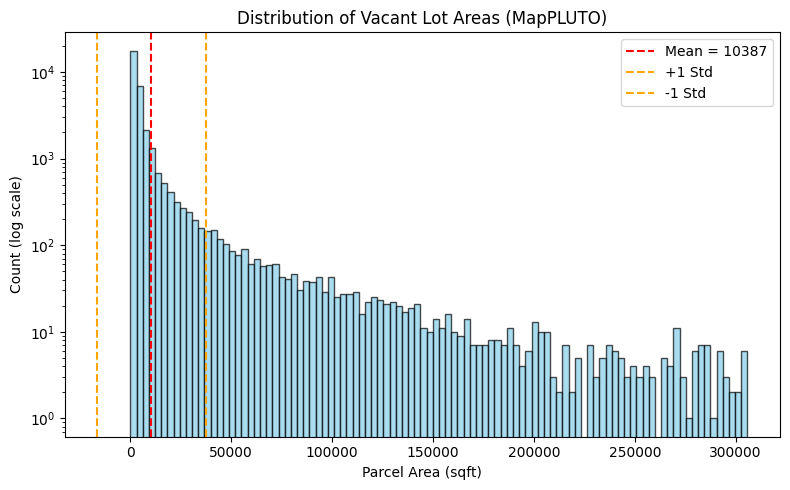

In [27]:
import matplotlib.pyplot as plt
import numpy as np

areas = within_1std["Shape_Area"]

plt.figure(figsize=(8,5))
plt.hist(areas, bins=100, color="skyblue", edgecolor="black", alpha=0.7)
plt.yscale("log")  # log scale helps reveal distribution
plt.xlabel("Parcel Area (sqft)")
plt.ylabel("Count (log scale)")
plt.title("Distribution of Vacant Lot Areas (MapPLUTO)")

mean = areas.mean()
std = areas.std()
plt.axvline(mean, color="red", linestyle="--", label=f"Mean = {mean:.0f}")
plt.axvline(mean + std, color="orange", linestyle="--", label="+1 Std")
plt.axvline(mean - std, color="orange", linestyle="--", label="-1 Std")
plt.legend()
plt.tight_layout()
plt.show()

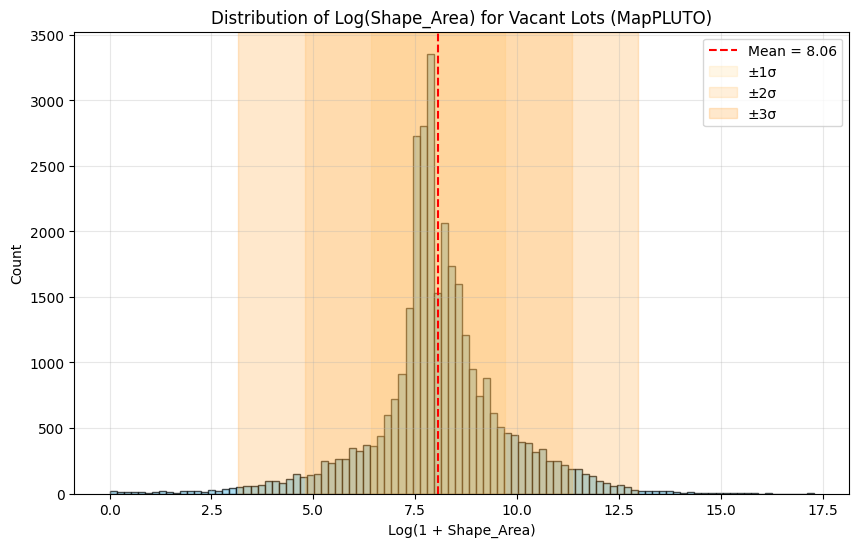

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Get area column and log-transform it
areas = vacant_lots["Shape_Area"]
log_areas = np.log1p(areas)  # log(1 + x) to handle zeros safely

# Compute stats in log-space
mean = log_areas.mean()
std = log_areas.std()

# Define ranges
ranges = {
    "±1σ": (mean - std, mean + std),
    "±2σ": (mean - 2*std, mean + 2*std),
    "±3σ": (mean - 3*std, mean + 3*std)
}

# Plot setup
plt.figure(figsize=(10, 6))
plt.hist(log_areas, bins=100, color="skyblue", edgecolor="black", alpha=0.7)
plt.title("Distribution of Log(Shape_Area) for Vacant Lots (MapPLUTO)")
plt.xlabel("Log(1 + Shape_Area)")
plt.ylabel("Count")

# Add mean line
plt.axvline(mean, color="red", linestyle="--", label=f"Mean = {mean:.2f}")

# Add shaded std regions
colors = ["#FFD580", "#FFB347", "#FF8C00"]
for i, (label, (low, high)) in enumerate(ranges.items()):
    plt.axvspan(low, high, color=colors[i], alpha=0.2, label=label)

plt.legend()
plt.grid(alpha=0.3)
plt.show()


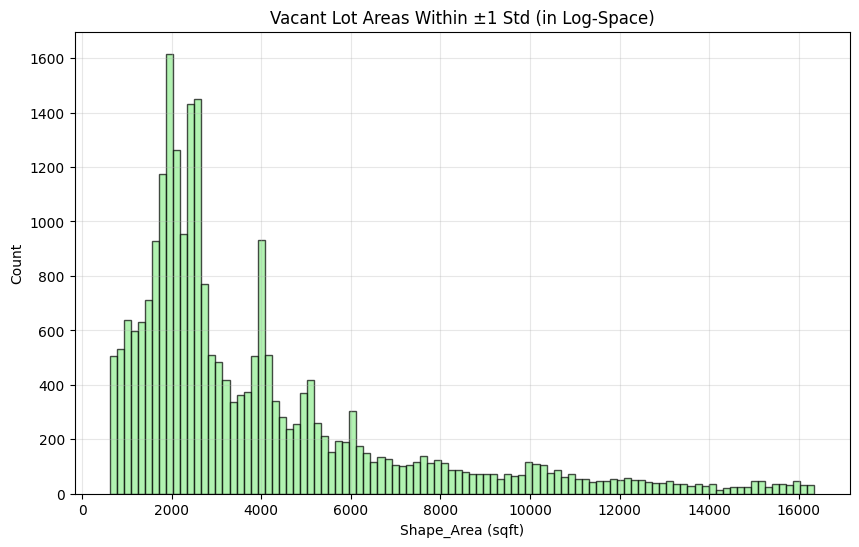


--- Stats for 1 Std Dev Subset ---
count    25189.000000
mean      3966.351043
std       3150.403401
min        616.880274
25%       1947.611870
50%       2690.403876
75%       4935.395805
max      16347.916996
Name: Shape_Area, dtype: float64
Count: 25,189 of 32,985 total lots (76.37%)


In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: compute log stats
areas = vacant_lots["Shape_Area"]
log_areas = np.log1p(areas)  # safe log transform
mean = log_areas.mean()
std = log_areas.std()

# Step 2: get subset within ±1 std (in log-space)
mask_1std = (log_areas >= mean - std) & (log_areas <= mean + std)
vacant_lots_1std = vacant_lots[mask_1std]

# Step 3: plot histogram of actual (non-log) Shape_Area
plt.figure(figsize=(10, 6))
plt.hist(vacant_lots_1std["Shape_Area"], bins=100, color="lightgreen", edgecolor="black", alpha=0.7)
plt.title("Vacant Lot Areas Within ±1 Std (in Log-Space)")
plt.xlabel("Shape_Area (sqft)")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()

# Optional: print quick stats
print("\n--- Stats for 1 Std Dev Subset ---")
print(vacant_lots_1std["Shape_Area"].describe())
print(f"Count: {len(vacant_lots_1std):,} of {len(vacant_lots):,} total lots "
      f"({len(vacant_lots_1std)/len(vacant_lots)*100:.2f}%)")


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_landuse_distribution(gdf: pd.DataFrame, area_col: str = "Shape_Area", 
                              landuse_col: str = "LandUse", 
                              min_area: float = 2000, max_area: float = 16000):
    """
    Filter parcels by area range and plot the LandUse distribution with counts and percentages.
    
    Args:
        gdf: GeoDataFrame or DataFrame containing parcel data
        area_col: Name of the column with parcel area (sqft)
        landuse_col: Column indicating land use category
        min_area: Minimum area (inclusive)
        max_area: Maximum area (inclusive)
    """
    # Filter by area range
    filtered = gdf[(gdf[area_col] >= min_area) & (gdf[area_col] <= max_area)].copy()
    
    if filtered.empty:
        print("No parcels found in this area range.")
        return

    # Compute counts and percentages
    landuse_counts = (
        filtered[landuse_col]
        .value_counts(dropna=False)
        .rename_axis("LandUse")
        .reset_index(name="Count")
    )
    landuse_counts["Percent"] = (landuse_counts["Count"] / landuse_counts["Count"].sum()) * 100

    # Sort by count for clearer plotting
    landuse_counts = landuse_counts.sort_values("Count", ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=landuse_counts, 
        x="LandUse", 
        y="Count", 
        palette="crest"
    )
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Land Use Distribution for Parcels ({min_area}-{max_area} sq ft)\n"
              f"Total parcels: {len(filtered):,}")
    plt.xlabel("Land Use")
    plt.ylabel("Count")

    # Add text annotations (counts and %)
    for idx, row in landuse_counts.iterrows():
        plt.text(
            x=idx, 
            y=row["Count"] + 5, 
            s=f"{row['Count']:,}\n({row['Percent']:.1f}%)",
            ha='center', 
            va='bottom', 
            fontsize=9
        )
    print(f"Total parcels in range {min_area}-{max_area} sq ft: {len(filtered):,}")
    return filtered, landuse_counts

In [33]:
mappluto_22_gdb

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,PFIRM15_FLAG,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry,geom_perimeter
0,MN,1,101,101.0,1000100,None,1,1001,02,1.0,...,1,22v3,None,40.689920,-74.045337,None,0.0,5.018973e+05,"MULTIPOLYGON (((972409.69 190685.56, 972428.82...",3940.841176
1,MN,1,10,101.0,1000500,10005000003,5,1000,02,1.0,...,1,22v3,None,40.688766,-74.018682,None,0.0,7.478663e+06,"MULTIPOLYGON (((980783.787 191526.763, 980898....",13432.373392
2,MN,1,111,101.0,1000500,10005001003,5,1000,02,1.0,...,1,22v3,None,40.692922,-74.017637,None,0.0,6.445095e+04,"MULTIPOLYGON (((979185.332 191646.482, 979184....",1076.168021
3,MN,2,2,101.0,1000900,10009001022,9,1025,02,1.0,...,1,22v3,None,40.700550,-74.011588,None,0.0,8.724425e+04,"MULTIPOLYGON (((980915.002 194319.141, 980795....",2411.869934
4,MN,2,23,101.0,1000900,10009001022,9,1025,02,1.0,...,1,22v3,t,40.701171,-74.009243,None,0.0,9.690237e+04,"MULTIPOLYGON (((981182.221 194851.167, 981181....",2949.778901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856993,SI,8050,83,503.0,5024800,50248001014,248,1016,31,51.0,...,None,22v3,None,40.509152,-74.250189,None,0.0,5.078837e+03,"MULTIPOLYGON (((914740.567 124877.857, 914639....",314.140612
856994,SI,8050,86,503.0,5024800,50248001014,248,1016,31,51.0,...,None,22v3,None,40.508963,-74.250274,None,0.0,1.318642e+04,"MULTIPOLYGON (((914777.738 124829.873, 914552....",577.710853
856995,SI,8050,89,503.0,5024800,50248001014,248,1016,31,51.0,...,None,22v3,None,40.508834,-74.250187,None,0.0,1.247200e+04,"MULTIPOLYGON (((914810.954 124786.995, 914707....",614.219804
856996,SI,8050,92,503.0,5024800,50248001014,248,1016,31,51.0,...,None,22v3,None,40.508794,-74.249856,None,0.0,5.976783e+03,"MULTIPOLYGON (((914842.706 124746.005, 914775....",340.925638


Total parcels in range 2000-16000 sq ft: 645,427


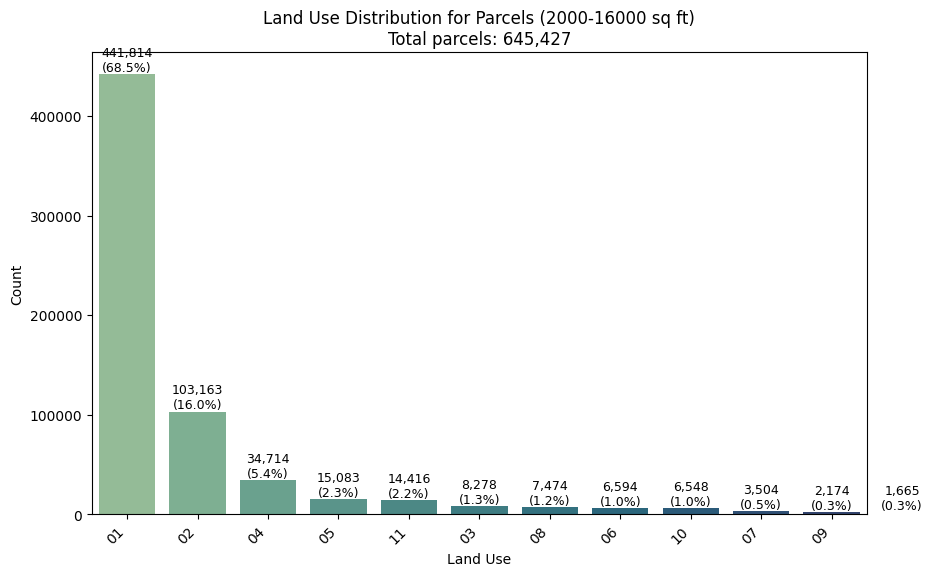

In [35]:
filtered_vacant, landuse_summary = plot_landuse_distribution(
    mappluto_22_gdb,
    area_col="Shape_Area",
    landuse_col="LandUse",
    min_area=2000,
    max_area=16000
)

Total parcels in range 0-16000000 sq ft: 856,978


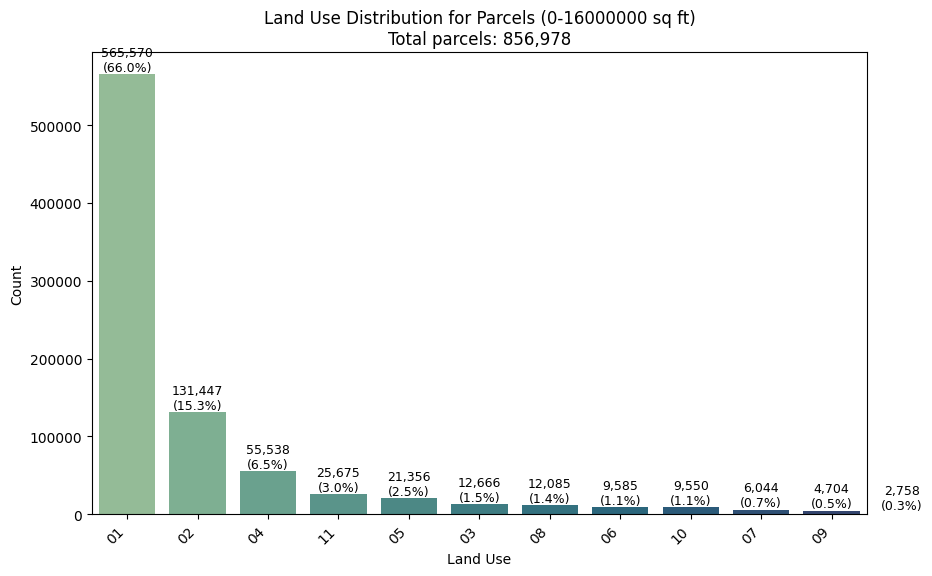

In [38]:
filtered_vacant, landuse_summary = plot_landuse_distribution(
    mappluto_22_gdb,
    area_col="Shape_Area",
    landuse_col="LandUse",
    min_area=0,
    max_area=16000000
)

In [13]:
def stratified_sample(gdf, landuse_col='LandUse', total_samples=25000, vacant_min_frac=0.08, random_state=42):
    np.random.seed(random_state)

    # Count per class
    landuse_counts = gdf[landuse_col].value_counts(normalize=True)

    # Target sample size per class (proportional)
    target_per_class = (landuse_counts * total_samples).astype(int)

    # Force minimum % for Vacant Land (LandUse == 11)
    if "11" in target_per_class.index:
        vacant_target = max(int(total_samples * vacant_min_frac), target_per_class["11"])
        target_per_class["11"] = vacant_target

        # Rebalance others so total ≈ total_samples
        total_current = target_per_class.sum()
        scale = (total_samples - vacant_target) / (total_current - vacant_target)
        for lu in target_per_class.index:
            if lu != "11":
                target_per_class[lu] = int(target_per_class[lu] * scale)

    # Draw samples
    samples = []
    for lu, n in target_per_class.items():
        subset = gdf[gdf[landuse_col] == lu]
        if len(subset) > 0:
            n = min(n, len(subset))
            samples.append(subset.sample(n=n, random_state=random_state))
    sampled_gdf = pd.concat(samples)

    print(f"✅ Stratified sample created: {len(sampled_gdf):,} lots")
    print(sampled_gdf[landuse_col].value_counts(normalize=True).round(3))

    return sampled_gdf


In [14]:
filtered_by_shape_area = mappluto_22_gdb[(mappluto_22_gdb["Shape_Area"] >= 2000) & (mappluto_22_gdb["Shape_Area"] <= 16000)]
sampled_gdf = stratified_sample(filtered_by_shape_area, "LandUse", 25000, 0.08, 34)

✅ Stratified sample created: 24,996 lots
LandUse
01    0.646
02    0.151
11    0.080
04    0.051
05    0.022
03    0.012
08    0.011
06    0.010
10    0.010
07    0.005
09    0.003
Name: proportion, dtype: float64


In [48]:
sampled_gdf

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,PFIRM15_FLAG,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry,geom_perimeter
102741,BX,3687,25,209.0,2009800,20098001001,98,1001,08,18.0,...,None,22v3,None,40.825755,-73.851137,None,0.0,2564.756050,"MULTIPOLYGON (((1025446.495 240104.224, 102542...",257.428846
484962,QN,8551,2,413.0,4155104,41551042012,1551.02,3012,26,23.0,...,None,22v3,None,40.751030,-73.706036,None,0.0,6031.187139,"MULTIPOLYGON (((1065756.69 213025.63, 1065717....",320.661071
723967,QN,9781,1,408.0,4044800,40448002000,448,2000,28,24.0,...,None,22v3,None,40.711760,-73.803367,None,0.0,3999.982182,"MULTIPOLYGON (((1038711.381 198662.895, 103881...",280.000090
562687,QN,1660,60,403.0,4036700,40367002002,367,2002,30,21.0,...,None,22v3,None,40.762544,-73.867479,None,0.0,4592.545218,"MULTIPOLYGON (((1020906.634 217108.129, 102098...",294.860044
451514,QN,6435,40,408.0,4080302,40803023006,803.02,3013,25,24.0,...,None,22v3,None,40.739678,-73.819238,None,0.0,2337.853026,"MULTIPOLYGON (((1034373.361 208854.572, 103433...",247.039722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712182,SI,5753,45,503.0,5017007,None,170.07,1000,31,51.0,...,None,22v3,t,40.558123,-74.188422,None,0.0,2052.953003,"MULTIPOLYGON (((931923.522 142662.919, 931883....",225.853817
153700,BK,3316,25,304.0,3043300,30433001001,433,1001,32,37.0,...,None,22v3,t,40.697645,-73.917199,None,0.0,2436.258634,"MULTIPOLYGON (((1007238.248 193452.812, 100725...",250.980190
255518,BK,7071,27,313.0,3035200,None,352,1022,21,47.0,...,1,22v3,t,40.572907,-73.988773,None,0.0,2050.260860,"MULTIPOLYGON (((987422.399 148019.222, 987424....",256.883715
303099,BK,3510,7,316.0,3090000,30900005000,900,5000,17,41.0,...,None,22v3,t,40.665997,-73.921203,None,0.0,2511.805478,"MULTIPOLYGON (((1006162.659 181927.044, 100616...",254.044827


In [54]:
mappluto_22_gdb.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCenterDistrict', 'HealthArea', 'Sanitboro', 'SanitDistrict',
       'SanitSub', 'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3',
       'ZoneDist4', 'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3',
       'LtdHeight', 'SplitZone', 'BldgClass', 'LandUse', 'Easements',
       'OwnerType', 'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea',
       'OfficeArea', 'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea',
       'OtherArea', 'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes',
       'UnitsTotal', 'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext',
       'ProxCode', 'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand',
       'AssessTot', 'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2',
       'HistDist', 'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR',
       'BoroCode', 'BBL', 'Cond

In [56]:
mappluto_22_gdb["BBL"].is_unique

True

In [57]:
mappluto_22_gdb["BBL"].isna().sum()

np.int64(0)

In [58]:
mappluto_features = numerical_features + categorical_features + ["geometry", "BBL"]
mappluto_features

['Shape_Area',
 'geom_perimeter',
 'BldgArea',
 'BuiltFAR',
 'NumBldgs',
 'YearBuilt',
 'AssessLand',
 'AssessTot',
 'NumFloors',
 'UnitsRes',
 'LotFront',
 'LotDepth',
 'LandUse',
 'Borough',
 'BldgClass',
 'OwnerType',
 'ZoneDist1',
 'geometry',
 'BBL']

In [52]:
sampled_gdf[mappluto_features]

,Shape_Area,geom_perimeter,BldgArea,BuiltFAR,NumBldgs,YearBuilt,AssessLand,AssessTot,NumFloors,UnitsRes,LotFront,LotDepth,LandUse,Borough,BldgClass,OwnerType,ZoneDist1,geometry
102741,2564.756050,257.428846,1748.0,0.68,2.0,1915.0,8400.0,36000.0,2.00,2.0,25.00,103.00,01,BX,B3,None,R3-2,"MULTIPOLYGON (((1025446.495 240104.224, 102542..."
484962,6031.187139,320.661071,2000.0,0.33,1.0,2008.0,25920.0,68040.0,2.00,1.0,60.00,100.00,01,QN,A1,None,R2A,"MULTIPOLYGON (((1065756.69 213025.63, 1065717...."
723967,3999.982182,280.000090,2457.0,0.61,3.0,1920.0,20340.0,66540.0,2.75,2.0,40.00,100.00,01,QN,B3,None,R4A,"MULTIPOLYGON (((1038711.381 198662.895, 103881..."
562687,4592.545218,294.860044,2298.0,0.51,2.0,1925.0,11460.0,52980.0,2.50,1.0,45.00,100.00,01,QN,A1,None,R3X,"MULTIPOLYGON (((1020906.634 217108.129, 102098..."
451514,2337.853026,247.039722,2475.0,1.02,1.0,1950.0,10020.0,71700.0,2.00,2.0,24.25,100.00,01,QN,B1,None,R4,"MULTIPOLYGON (((1034373.361 208854.572, 103433..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712182,2052.953003,225.853817,0.0,0.00,0.0,0.0,55800.0,55800.0,NaN,0.0,53.00,98.58,09,SI,Q0,C,PARK,"MULTIPOLYGON (((931923.522 142662.919, 931883...."
153700,2436.258634,250.980190,0.0,0.00,0.0,0.0,36000.0,36000.0,NaN,0.0,25.00,100.00,09,BK,Q1,C,R6,"MULTIPOLYGON (((1007238.248 193452.812, 100725..."
255518,2050.260860,256.883715,0.0,0.00,0.0,0.0,12978.0,12978.0,NaN,0.0,20.00,108.50,09,BK,Q2,C,R5,"MULTIPOLYGON (((987422.399 148019.222, 987424...."
303099,2511.805478,254.044827,0.0,0.00,0.0,0.0,117900.0,117900.0,NaN,0.0,25.00,100.00,09,BK,Q1,O,R6,"MULTIPOLYGON (((1006162.659 181927.044, 100616..."


- set a min lot area to 2000

In [68]:
from sklearn.preprocessing import MinMaxScaler

def normalize_spectral_features(df):
    df = df.copy()
    
    # Convert reflectances to [0,1]
    for band in ["R", "G", "B", "N"]:
        if df[band].max() > 1:
            df[band] = df[band] / 255.0
    
    # Log-transform GLCM features to reduce skew
    glcm_cols = [c for c in df.columns if "GLCM" in c]
    df[glcm_cols] = np.log1p(df[glcm_cols])  # log(1+x)
    
    # MinMax scale everything for comparability (0–1)
    scaler = MinMaxScaler()
    scaled_cols = ["R", "G", "B", "N", "NDVI", "SAVI", 
                   "Brightness", "BareSoilProxy"] + glcm_cols
    
    df[scaled_cols] = scaler.fit_transform(df[scaled_cols])
    
    return df

In [81]:
import ee

def normalize_reflectance(image):
    """Scales reflectance bands (0–255) to 0–1 range."""
    bands = ['R', 'G', 'B', 'N']
    return image.select(bands).divide(255).rename(bands)


def normalize_glcm(image, glcm_bands:list):
    """Applies log1p scaling to GLCM texture bands."""
    glcm=image.select(glcm_bands)
    return glcm.add(1).log().rename(glcm_bands)


def minmax_normalize(image, region, scale=20):
    """Per-band min-max normalization over a region."""
    band_names = image.bandNames()

    def scale_band(band_name, prev):
        prev = ee.Image(prev)
        band_name = ee.String(band_name)
        b = image.select(band_name)
        stats = b.reduceRegion(
            reducer=ee.Reducer.minMax(),
            geometry=region,
            scale=scale,
            maxPixels=1e8
        )
        min_val = ee.Number(stats.get(band_name.cat("_min")))
        max_val = ee.Number(stats.get(band_name.cat("_max")))
        scaled = b.subtract(min_val).divide(max_val.subtract(min_val)).rename(band_name)
        return prev.addBands(scaled)

    # iterate over all bands to combine them into one image
    first = ee.Image(0).select([])
    scaled_image = ee.Image(band_names.iterate(scale_band, first))
    return scaled_image.rename(band_names)


In [82]:
naip_rgb_norm = normalize_reflectance(naip_2022_nyc)

glcm_bands = glcm_image.bandNames().getInfo() + glcm_R_image.bandNames().getInfo()

glcm_norm = normalize_glcm(naip_2022_nyc, glcm_bands=glcm_bands)

composite = naip_rgb_norm.addBands(glcm_norm)

normalized_image = minmax_normalize(composite, nyc_geom)

In [91]:
naip_rgb_norm = normalize_reflectance(naip_2022_nyc)
naip_rgb_norm.getInfo()

{'type': 'Image',
 'bands': [{'id': 'R',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': 0,
    'max': 1},
   'dimensions': [48, 10],
   'origin': [-121, 32],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'G',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': 0,
    'max': 1},
   'dimensions': [48, 10],
   'origin': [-121, 32],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'B',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': 0,
    'max': 1},
   'dimensions': [48, 10],
   'origin': [-121, 32],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'N',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': 0,
    'max': 1},
   'dimensions': [48, 10],
   'origin': [-121, 32],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}],
 'properties': {'system:footprint': {'type': 'GeometryCollection',
   'geometrie

In [90]:
min_rgb = naip_rgb_norm.getInfo().get("bands")[0].get("data_type").get("min")
max_rgb = naip_rgb_norm.getInfo().get("bands")[0].get("data_type").get("max")

0

In [92]:
glcm_norm = normalize_glcm(naip_2022_nyc, glcm_bands=glcm_bands)
glcm_norm.getInfo()

{'type': 'Image',
 'bands': [{'id': 'GLCM_N_ASM',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [48, 10],
   'origin': [-121, 32],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'GLCM_N_Contrast',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [48, 10],
   'origin': [-121, 32],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'GLCM_N_Dissimilarity',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [48, 10],
   'origin': [-121, 32],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'GLCM_N_Entropy',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [48, 10],
   'origin': [-121, 32],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'GLCM_N_Homogeneity',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [48, 10],
   'origin': [-121, 32],
   'c

In [109]:
nyc_geom.projection()

In [110]:
GLCM_N_ASM.projection()

In [112]:
GLCM_N_ASM = glcm_norm.select("GLCM_N_ASM")
stats = GLCM_N_ASM.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=nyc_geom,
    scale=10,
    maxPixels=1e9,
    bestEffort=True
)
print(stats.getInfo())

EEException: Computation timed out.

In [ ]:
import geemap
import ee

# pick a representative band — contrast tends to have the largest spread
band = "GLCM_N_Contrast"

# Center the map over your study region
Map = geemap.Map(center=[40.7, -73.95], zoom=13)

# Visualization stretch — adjust if needed
vis_params = {"min": 0, "max": 5000, "palette": ["blue", "white", "red"]}
vis_params_norm = {"min": 0, "max": 1, "palette": ["blue", "white", "red"]}

# Add original GLCM contrast band
Map.addLayer(glcm_image.select(band), vis_params, f"{band} (Original)")

# Add normalized GLCM contrast band
Map.addLayer(glcm_norm.select(band), vis_params_norm, f"{band} (Normalized)")

# Add boundary or region outline for context
Map.addLayer(nyc_geom, {"color": "black"}, "NYC Region")

Map


In [67]:
import geopandas as gpd
import ee

sampled_gdf= sampled_gdf.to_crs(epsg=4326)
parcel = sampled_gdf.iloc[0]
parcel_geom = parcel.geometry

# TODO add crs to config 
parcel_ee_geom = geemap.geopandas_to_ee(gpd.GeoDataFrame([parcel], crs="EPSG:4326"))
clipped_image = naip_2022_nyc.clip(parcel_ee_geom)
band_names = clipped_image.bandNames()
mean_dict = clipped_image.reduceRegion(reducer=ee.Reducer.mean(),
                                       geometry=parcel_ee_geom.geometry(),
                                       scale =1,
                                       maxPixels=1e8)

mean_values = mean_dict.getInfo()

for band, val in mean_values.items():
    print(f"  {band}: {val:.4f}" if val is not None else f"  {band}: None")


# ---- visualize on a geemap Map ----
Map = geemap.Map(center=[parcel_geom.centroid.y, parcel_geom.centroid.x], zoom=19)
Map.addLayer(
    clipped_image,
    {'bands': ['R', 'G', 'B'], 'min': 0, 'max': 255},
    'Clipped NAIP'
)

Map.addLayer(naip_2022_nyc, {'color': 'red'}, "Naip" )
Map.addLayer(clipped_image, {'color': 'red'}, "clipped" )
Map.addLayer(parcel_ee_geom, {'color': 'red'}, 'Parcel Boundary')
Map

  B: 131.7849
  BareSoilProxy: 0.4613
  Brightness: 0.4987
  G: 127.6750
  GLCM_N_ASM: 0.0150
  GLCM_N_Contrast: 1156.3459
  GLCM_N_Dissimilarity: 21.6625
  GLCM_N_Entropy: 4.2606
  GLCM_N_Homogeneity: 0.1022
  GLCM_R_ASM: 0.0157
  GLCM_R_Contrast: 1367.6565
  GLCM_R_Dissimilarity: 23.0042
  GLCM_R_Entropy: 4.2291
  GLCM_R_Homogeneity: 0.1164
  N: 150.2675
  NDVI: 0.1133
  R: 122.0800
  SAVI: 0.1696


Map(center=[40.82575646536141, -73.85113638298648], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
def compute_means_for_batch(batch_gdf, image):
    results = []
    for i, row in batch_gdf.iterrows

In [6]:
task = export_image_to_gee(
    image = naip_2022_nyc,
    description="export naip 2022 nyc image scale 1",
    asset_id=f"projects/{CONFIG.EARTH_ENGINE.PROJECT_ID}/assets/test",
    scale = 1
)

21:47:39 | INFO | vacant_lots |  Starting export to GEE Asset: projects/vacant-lot-detection/assets/test
21:47:39 | INFO | vacant_lots | Export task started. Monitor progress in Earth Engine Code Editor Tasks tab


In [15]:
"""
cool i decided to sample 25k parcels and cluster those since 800k is way too much, im pretty sure theres some size constraints 
here as well and a distribution was forces to match the vacant land
"""

#get 5 parcels
five_parcels = sampled_gdf.iloc[0:5]
five_parcels["geometry"]

naip_2022_test = get_naip_2022_nyc()

In [18]:
naip_2022_test_N = naip_2022_test.select("N")
image = naip_2022_test_N.glcmTexture()
image

/Users/joyadebi/repos/Vacant_Lot_Detection/.venv/lib/python3.12/site-packages/IPython/core/formatters.py:406: UserWarning: Getting info failed with: 'User memory limit exceeded.'. Falling back to string repr.
  return method()


In [27]:
# Get list of bands
band_names = naip_2022_nyc.bandNames().getInfo()
print("NAIP Bands:", band_names)

# Define visualization parameters for each texture band
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['000000', 'FFFFFF']  # grayscale
}

# Create map
m = geemap.Map(center=[40.7128, -74.0060], zoom=10)

# Add each GLCM band as a separate layer
for band in band_names:
    m.addLayer(naip_2022_nyc.select(band), vis_params, band)

# Optional: add basemap and layer control
m.add_basemap('HYBRID')
m.addLayerControl()

m

EEException: User memory limit exceeded.